In [1]:
import time
import sys

sys.path.append('/home/cjw/Code/Unet')
#sys.path.append('/media/cjw/PythonLib/Unet')
from skimage.io import imread
from skimage.transform import resize
from matplotlib import pyplot as plt
import numpy as np

import unet3d

%matplotlib inline

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/ten

In [2]:
import tensorflow as tf

In [3]:
params = dict()

params['width'] = 256
params['height'] = 256
params['depth'] = 8
params['nchannels'] = 2
params['channels'] = [0, 1]
params['nepochs'] = [1]
params['batchsize'] = [16]
params['learning_rate'] = 0.001
params['restore'] = False
params['latent_size'] = 1
params['enc_sizes'] = [[32,3, (2,2,2)], [64, 3, (1,2,2)],
                       [128, 3, (1,2,2)], [256, 3, (1,2,2)]]

params['dec_sizes'] = [[128,3, (1,2,2)], [64, 3, (1,2,2)],
                       [32, 3, (1,2,2)], [1, 3, (2,2,2)]] #[params['nchannels'], 3, (2,2,2)]]
params['droprate'] = 0.1
params['stdev'] = 0.0001

In [4]:

tf.reset_default_graph()
u = unet3d.unet3d(params)


In [5]:
#u.read_images('/ssd1/cjw/Data/Nuclei.tif')
u.read_mm('/n/core/micro/asa/fgm/smc/20190919_Screen/cjw_training/data.mm', shape=(960, 8, 3, 256, 256))
u.x = np.moveaxis(u.x, 2, -1)
#u.x = u.x[:,:,:,:,:]
u.x.shape, u.x.min(), u.x.max()

((960, 8, 256, 256, 3), -5.035897e-05, 1.0049772)

In [6]:
u.x = u.x[np.where(u.x[:,:,:,:,2].max(axis=(1,2,3)) > .1)[0]]
u.x.shape

(252, 8, 256, 256, 3)

-8.423314e-06
0.64114225


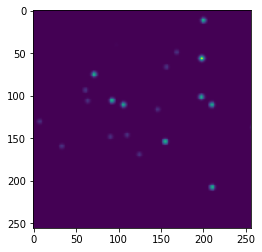

In [7]:
# b = np.reshape(u.x, (720,48, 2, 256, 256, 2))
# b0 = b[:,:,:,:,:,0]
# b1 = b[:,:,:,:,:,1]
# v0 = b0.mean(axis=2)
# v1 = b1.max(axis=2)

print(u.x[36, 5, :,:,2].min())
print(u.x[36, 5, :,:,2].max())
plt.imshow(u.x[36, 5, :,:,2])

In [8]:
v = u.x #np.stack([v0,v1], axis=-1)
print(v.shape)

(252, 8, 256, 256, 3)


In [9]:
if 1 == 0:
    count = 1
    plt.figure(figsize=(12,48))
    for i in range(16):
        for j in range(6):
            plt.subplot(16,7,count)
            plt.imshow(b[23,i, j, :,:, 0])
            count += 1
        plt.subplot(16,7, count)
        plt.imshow(v[23,i, :,:,0])
        count += 1
#a = u.get_batch(4, augment=True)
#ab = u.augment_batch(a)
#ab.shape

In [10]:
u.x = v

In [11]:
# from scipy.ndimage import rotate
# # angle = 90*np.random.randint(0,4)
# # print(angle)
# # s = a[2]
# #ar = rotate(a, 270, (1,2), reshape=False, order=1)
# plt.subplot(2,1,1)
# plt.imshow(a[1,:,:,47,0])
# plt.subplot(2,1,2)
# plt.imshow(a[1,:,:,47,1])
v0 = None
v1 = None
b = None

In [12]:
tf.reset_default_graph()
images = tf.placeholder(tf.float32, (None, 8, 256, 256, params['nchannels']))
masks = tf.placeholder(tf.float32, (None, 8, 256, 256, 1))
learning_rate = tf.placeholder(tf.float32, ())
u.learning_rate = learning_rate

In [13]:
enc = u.create_encoder(images, True)

[32, 3, (2, 2, 2)] <class 'tuple'>
Instructions for updating:
Use keras.layers.conv3d instead.
Instructions for updating:
Colocations handled automatically by placer.
[64, 3, (1, 2, 2)] <class 'tuple'>
[128, 3, (1, 2, 2)] <class 'tuple'>
[256, 3, (1, 2, 2)] <class 'tuple'>


In [14]:
d = u.create_decoder()
u.create_loss(masks)
u.create_opt()

Instructions for updating:
Use keras.layers.conv3d_transpose instead.
Tensor("Relu_3:0", shape=(?, 4, 32, 32, 128), dtype=float32)
3 Tensor("Relu_2:0", shape=(?, 4, 32, 32, 128), dtype=float32)
after concat Tensor("concat-128:0", shape=(?, 4, 32, 32, 256), dtype=float32)
Tensor("Relu_4:0", shape=(?, 4, 32, 32, 128), dtype=float32)
Tensor("Relu_5:0", shape=(?, 4, 64, 64, 64), dtype=float32)
2 Tensor("Relu_1:0", shape=(?, 4, 64, 64, 64), dtype=float32)
after concat Tensor("concat-64:0", shape=(?, 4, 64, 64, 128), dtype=float32)
Tensor("Relu_6:0", shape=(?, 4, 64, 64, 64), dtype=float32)
Tensor("Relu_7:0", shape=(?, 4, 128, 128, 32), dtype=float32)
1 Tensor("Relu:0", shape=(?, 4, 128, 128, 32), dtype=float32)
after concat Tensor("concat-32:0", shape=(?, 4, 128, 128, 64), dtype=float32)
Tensor("Relu_8:0", shape=(?, 4, 128, 128, 32), dtype=float32)
Tensor("decoder-layer-1/conv3d_transpose:0", shape=(?, 8, 256, 256, 1), dtype=float32)
0 Tensor("Placeholder:0", shape=(?, 8, 256, 256, 2), dtyp

(2, 8, 256, 256, 3)

In [15]:

u.xtrain = u.x[:-20]
u.xvalid = u.x[-20:]
#u.set_validation(20)

In [16]:
#u.x[26, 5, :,:,2]

tf.summary.scalar('loss', u.loss)
si = tf.slice(u.decoder, [5, 4, 0, 0, 0], [10,5,256,256, 1])

si = si[:,:,:,:,0]
print(si)
tf.summary.image('res', u.decoder, max_outputs=4)    
merged = tf.summary.merge_all()

sess = tf.Session()

logdir = "/scratch/cjw/fgm/logdir"
logwriter = tf.summary.FileWriter(logdir, sess.graph)

Tensor("strided_slice:0", shape=(10, 5, 256, 256), dtype=float32)


In [17]:
sess.run(tf.global_variables_initializer())

In [18]:
u.stdev = 0.02
#u.learning_rate = 0.0001

0.6931201 0.6905335 0.4955694 0.5


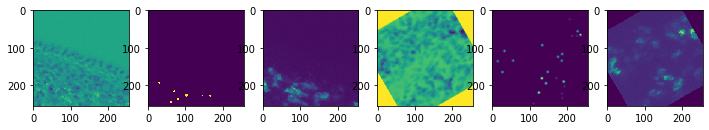

0.013424419 0.012757639 0.0 0.5


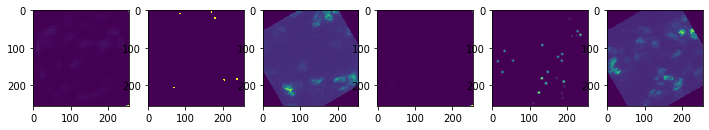

0.010531225 0.009530926 0.0 0.5


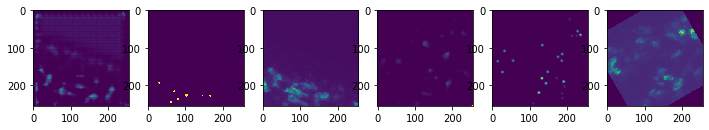

0.0077113183 0.0081671905 0.0 0.5


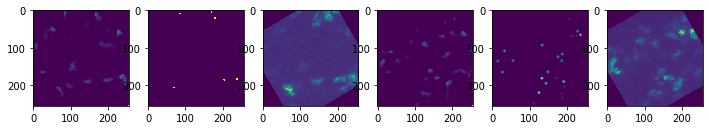

0.007894586 0.007167384 0.0 0.5


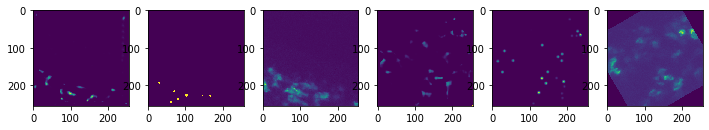

0.0052921427 0.0068920376 0.0 0.5218723


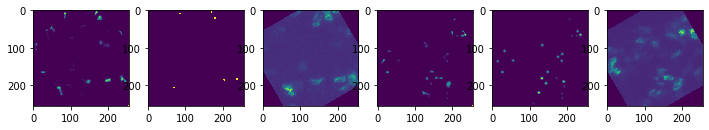

0.006864759 0.0062843077 0.0 0.7341002


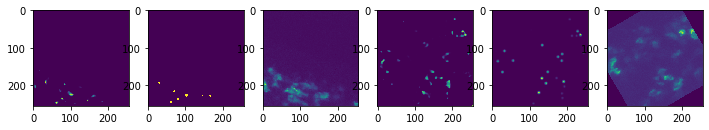

0.0038530605 0.006661278 0.0 0.90615016


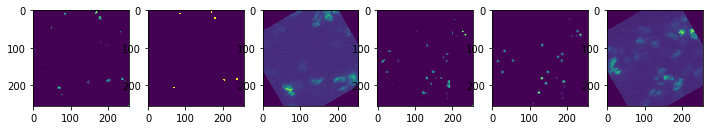

0.0062513514 0.0066784685 0.0 0.98980033


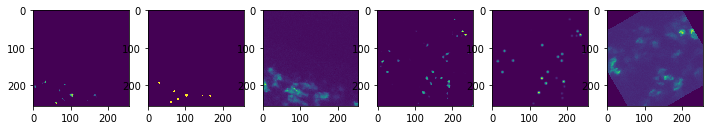

0.0024864553 0.0076943934 0.0 0.99952877


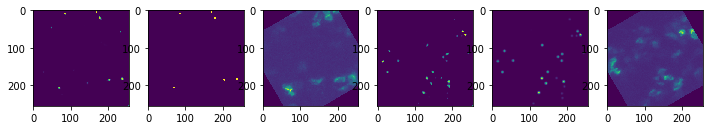

0.0053660786 0.008098369 0.0 0.9999533


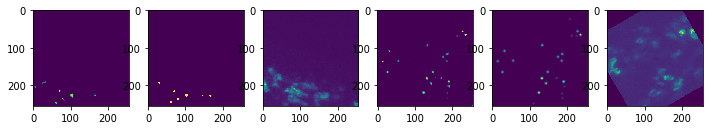

0.0018174646 0.009216316 0.0 0.9999908


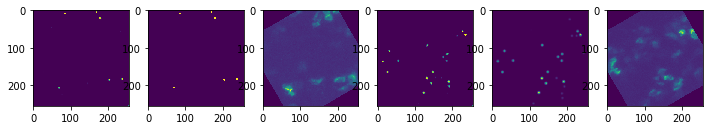

0.004766022 0.009160807 0.0 0.99999607


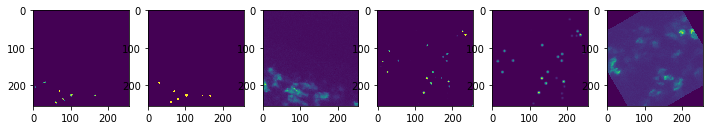

0.0014639405 0.010783447 0.0 1.0


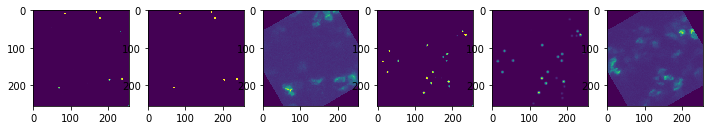

0.00399926 0.010676499 0.0 1.0


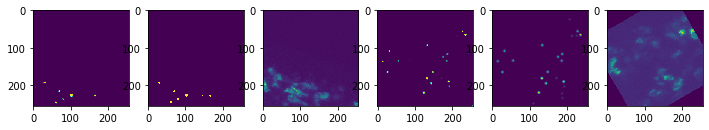

0.0014470322 0.010703076 0.0 0.9999999


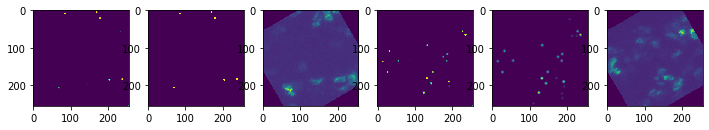

0.0035102793 0.0125428615 0.0 1.0


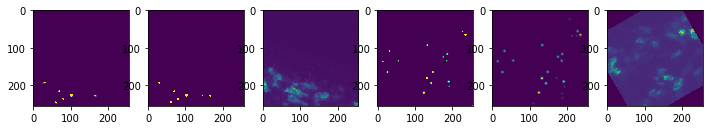

0.0011172974 0.012689287 0.0 1.0


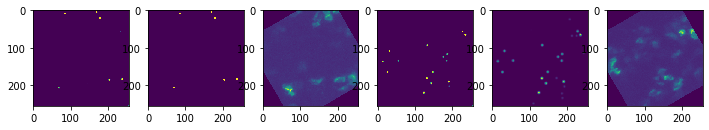

0.0032682451 0.0138999075 0.0 1.0


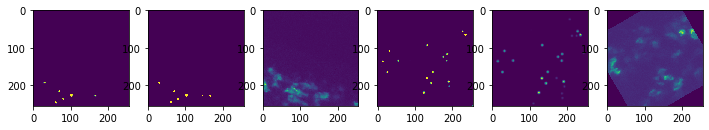

0.00096641935 0.014889419 0.0 1.0


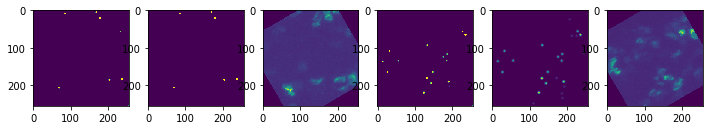

0.0029781843 0.015565944 0.0 1.0


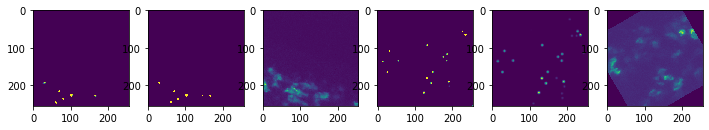

0.00083638023 0.01670498 0.0 1.0


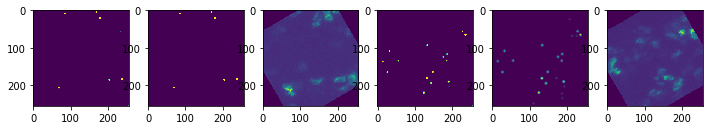

0.0026370962 0.017407745 0.0 1.0


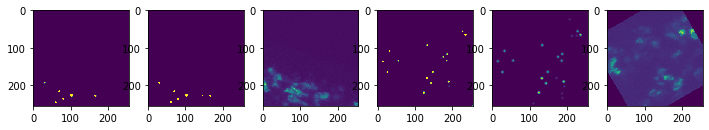

0.0008883537 0.018158756 0.0 1.0


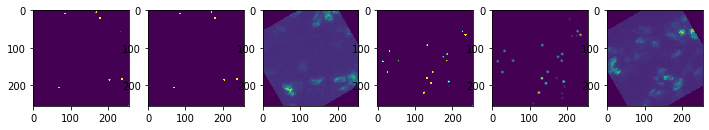

0.0024000383 0.018381756 0.0 1.0


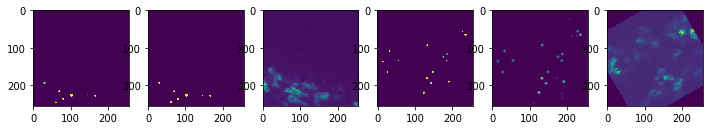

0.0007676877 0.019143637 0.0 1.0


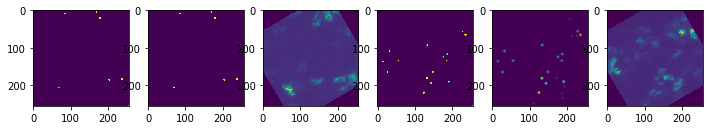

0.0023017277 0.020574225 0.0 1.0


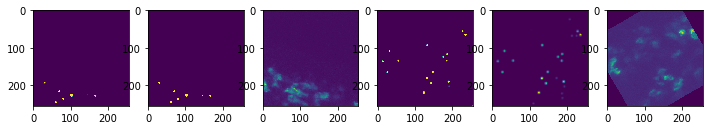

0.00074647425 0.01998156 0.0 1.0


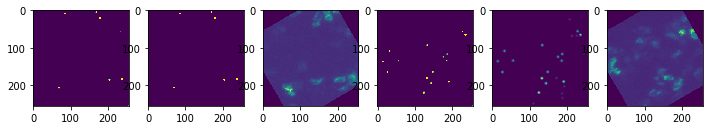

0.002036852 0.021328133 0.0 1.0


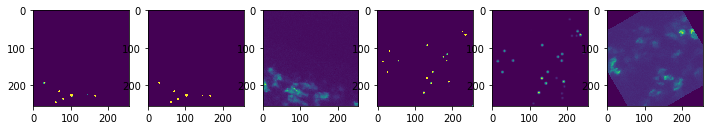

0.00064504624 0.022335406 0.0 1.0


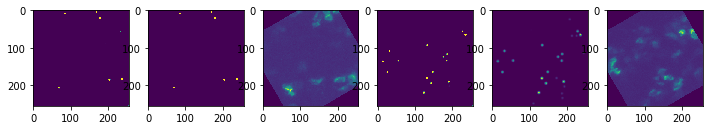

0.0021211964 0.02225671 0.0 1.0


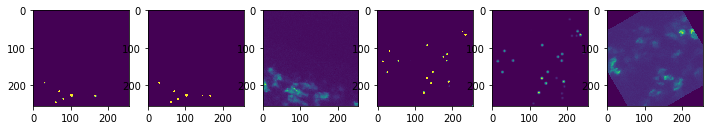

0.0006349055 0.024016378 0.0 1.0


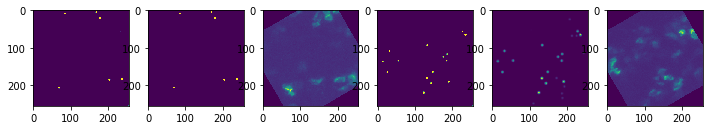

0.0018965498 0.024132093 0.0 1.0


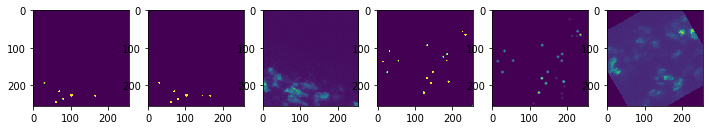

0.0006973326 0.02318253 0.0 1.0


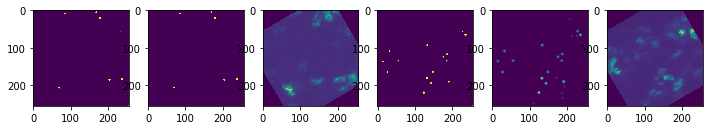

0.0016906618 0.025137916 0.0 1.0


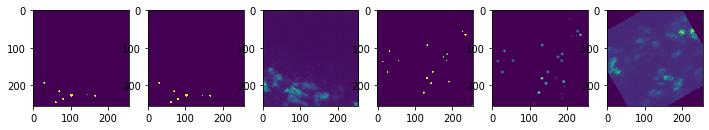

0.0005338932 0.026655367 0.0 1.0


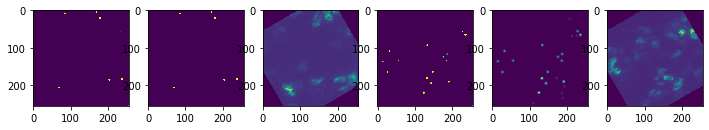

0.0015872547 0.027764034 0.0 1.0


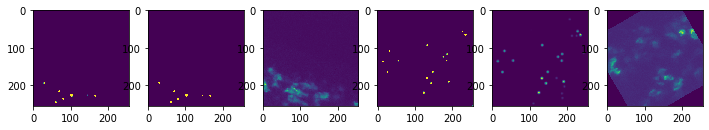

0.0005881927 0.028250435 0.0 1.0


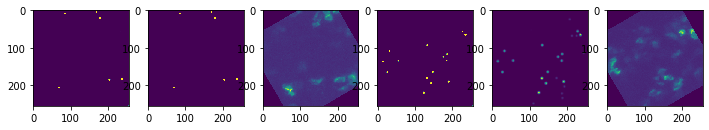

0.0014457135 0.028342659 0.0 1.0


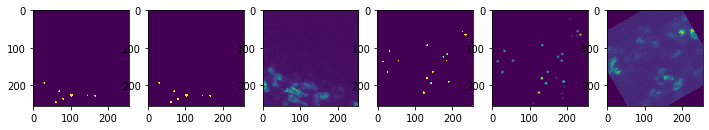

0.0006036128 0.030102665 0.0 1.0


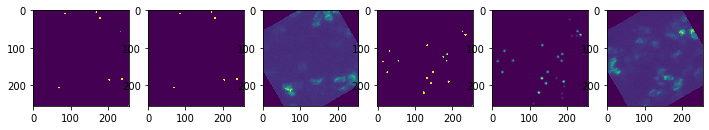

In [19]:


vx = u.xvalid[:,:,:,:,0:2]
vm = u.xvalid[:,:,:,:,[2]]

rate = 0.0007
#loss_file = open('progress.dat', 'w', buffering=1)
bindex = 0
for i in range(4000):
    t1 = time.time()
    rate = np.maximum(rate*.9991, 0.0001)
    batch = u.xtrain[bindex:bindex + 32,:,:,:,:]   #u.get_batch(16, augment=False)
    
    bindex += 32
    if bindex > u.xtrain.shape[0]:
        bindex = 0
    bx = batch[:,:,:,:,0:2]
    bm = batch[:,:,:,:,[2]]
    bm = np.where(bm > .25, 1.0, 0.0)
    #print(bx.shape, bm.shape)
    _, res, err = sess.run([u.opt, u.decoder_sigmoid, u.loss],
                           feed_dict={images:bx, masks:bm, learning_rate:rate})
    if i % 100 == 0:
        vres, verr = sess.run([u.decoder_sigmoid, u.loss],
                               feed_dict={images:vx, masks:vm})

        zm = vres[0,:,:,:,0].argmax(axis=(-1))
        print(err, verr, vres[0,:,:,:,0].min(), vres[0,:,:,:,0].max())
        #print(zm)
#         loss_file.write("*******{}, {}\n".format(err, verr))
        nr = 4 #np.random.randint(0,16)
        plt.figure(figsize=(12,2))
        plt.subplot(1,6,1)
        plt.imshow(res[nr,4,:,:,0])
        plt.subplot(1,6,2)
        plt.imshow(bm[nr,4,:,:,0])
        plt.subplot(1,6,3)
        plt.imshow(bx[nr, 4,:,:,0])
        plt.subplot(1,6,4)
        plt.imshow(vres[1, 5,:,:,0])
        plt.subplot(1,6,5)
        plt.imshow(vm[1, 5,:,:,0])
        plt.subplot(1,6,6)
        plt.imshow(vx[1, 5,:,:,0])
        plt.show()
        #plt.savefig("images/image{0:05d}".format(i))
    t2 = time.time()
#     if i % 20 == 0:
#         print(i, err, (t2 - t1), rate)
# #         loss_file.write("{}, {}, {}, {}\n".format(i, err, (t2 - t1), rate))
#         summary = sess.run(merged,
#                            feed_dict={images:vx, masks:vm})
#         logwriter.add_summary(summary, i)  

#loss_file.close()

In [21]:
saver = tf.train.Saver()
saver.save(sess, 'fgm/fgm_1.ckpt')

'fgm/fgm_1.ckpt'

In [43]:
val_res, val_loss = sess.run([u.decoder_sigmoid, u.loss],
                               feed_dict={images:vx, masks:vm})


In [42]:
val_res.shape, valtif.shape

((20, 8, 256, 256, 1), (2, 8, 256, 256, 3))

In [44]:
val_stack = np.concatenate([u.xvalid, val_res], axis=-1)
val_stack.shape

(20, 8, 256, 256, 4)

In [45]:
tifffile.imwrite('val_stack.tif', val_stack)

In [54]:
import tifffile
valtif = tifffile.imread('/n/core/micro/asa/fgm/smc/20190919_Screen/cjw_training/val_patches.tif')
valtif = np.moveaxis(valtif, 2, -1)
valtif.shape
valtif.max()

1.0

In [55]:
val_patches_res = sess.run([u.decoder_sigmoid],
                               feed_dict={images:valtif})

val_cat = np.concatenate([valtif, val_patches_res[0]], axis=-1)
tifffile.imwrite('/n/core/micro/asa/fgm/smc/20190919_Screen/cjw_training/val_patches_res.tif', val_cat)

In [ ]:
print(vx.shape, vm.shape, vres.shape)

xo = np.stack((vx, vm, vres), 4)
xo = np.squeeze(xo)
#xo = np.rollaxis(xo, 3, 1)
xo.shape

In [ ]:
smm = np.memmap('/media/cjw/Data/c3d0.mm', mode='w+', dtype=np.float32
                , shape=xo.shape)

print(type(smm))
smm[:] = xo[:]
print(type(smm))
smm.flush()
del smm

In [ ]:

import tifffile

In [ ]:
tifffile.imwrite('/ssd1/cjw/Data/w3_2-48.tif', xo)

In [ ]:
u.create_loss(masks)
ss = sess.run(u.loss, feed_dict={images:yy, masks:bb})

In [ ]:
ss.shape
plt.imshow(ss[0,:,:,44,0])

In [ ]:
rt = y[0,:,:,:,:]
from scipy.ndimage import rotate

res = rotate(rt, 45, (0, 1), order=2)

In [ ]:
plt.imshow(res[:,:,44,0])

In [ ]:
u.x.shape
u.used = None

In [ ]:
import pickle
from scipy.ndimage import rotate


def augment(b, da = 1):
    mm = np.memmap('/ssd1/cjw/Data/nuclei.mm', dtype=np.float32,
               mode='r+', shape=(720, 256, 256, 96, 2))
    nr = b.shape[0]
    d = dict()
    counter = 0
    for i in range(nr):
        print(i)
        s = b[i]  # this loses the first dimension
        mm[counter] = s
        counter += 1
        print(counter)
        angle = 0
        while angle < 360:
            angle += da
            mm[counter] = rotate(s, angle, (0,1), reshape=False, order=1)
            counter += 1
            print(counter)
            
        mm.flush()
    del mm
        
augment(u.x, 18)

In [ ]:
mm = np.memmap('/media/cjw/Data/nuclei.mm', dtype=np.float32,
               mode='r', shape=(720, 256, 256, 96, 2))

In [ ]:
plt.imshow(mm[-19,:,:,34,0])

In [ ]:
rf = .1
for i in range(20000):
    rf = rf*.9996
    
print(rf)